**Sentiment Analysis on Economic Texts**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load training dataset
df = pd.read_csv('/content/all-data.csv', names=['sentiment','sentence'], encoding='latin-1')
# Output first five rows
df.head() 

,sentiment,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


**Data** **Preprocessing**

In [ ]:
# Check for missing data
df.isnull().sum()

sentiment    0
sentence     0
dtype: int64

In [ ]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [ ]:
# The distribution of sentiments
df.groupby('sentiment').count().plot(kind='bar')

In [ ]:
df = df.rename(columns={'sentence': 'clean_text', 'sentiment':'category'})
df

,category,clean_text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
df['category'] = df['category'].map({'neutral': 'Neutral', 'positive': 'Positive', 'negative':'Negative'})

In [ ]:
# Calculate headline lengths
headline_len = pd.Series([len(headline.split()) for headline in df['clean_text']])

# The distribution of headline text lengths
headline_len.plot(kind='box')

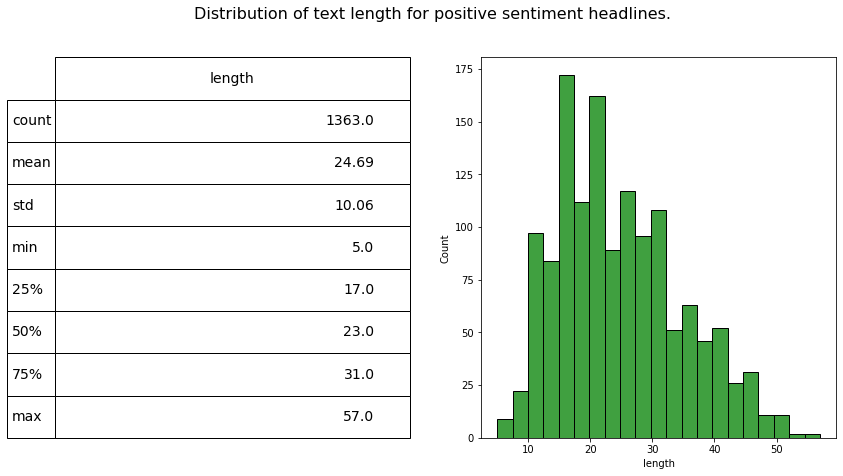

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment headlines.', fontsize=16)

plt.show()

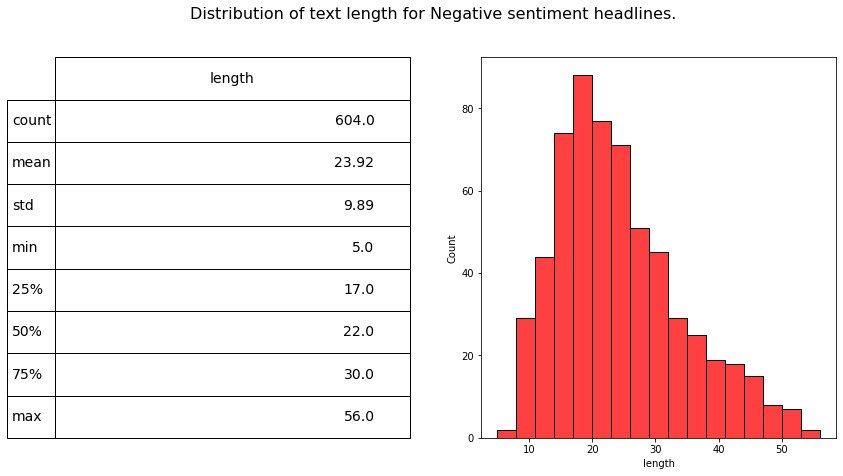

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment headlines.', fontsize=16)

plt.show()

In [ ]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of headlines')
fig.show()

**Processing** **Text**

In [ ]:
def headline_to_words(headline):
    ''' Convert headline text into a sequence of words '''
    
    # convert to lowercase
    text = headline.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal headline ->", df['clean_text'][0])
print("\nProcessed headline ->", headline_to_words(df['clean_text'][0]))


Original headline -> According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

Processed headline -> ['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']


In [ ]:
# Apply data processing to each headline
X = list(map(headline_to_words, df['clean_text']))

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [ ]:
print(X[0])
print(Y[0])

['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']
1


In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

**Feature** **Extraction**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# headline have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [ ]:
import sklearn.preprocessing as pr

#Normalize BoW features in training and test set
X_train = pr.normalize(X_train, axis=1)
X_test  = pr.normalize(X_test, axis=1)

In [ ]:
# print first 200 words/tokens
print(count_vector.get_feature_names()[0:200])

['0', '00', '000', '0025', '0030', '008', '01', '012', '0187274', '02', '023', '03', '030', '031', '04', '045', '046', '047', '05', '052', '06', '060', '063', '064', '07', '070', '08', '083', '084', '089', '09', '094', '0941', '1', '10', '100', '100mn', '101', '102', '1023', '103', '105', '106', '107', '10mn', '10th', '11', '110', '1112', '112', '113', '114', '115', '116', '117', '119', '11m', '12', '120', '122', '123', '125', '12mp', '12th', '13', '130', '133', '135', '138', '139', '14', '140', '141', '1411', '142', '143', '145', '146mn', '149', '14mn', '15', '150', '150mn', '151', '152', '154', '155', '156', '159', '15mn', '15th', '16', '160', '161', '162', '164', '1649', '167', '168', '17', '170', '172', '175', '1750', '177mn', '17m', '17mn', '18', '180', '180mn', '182', '184', '185', '186', '1862', '187', '189', '19', '190', '190mn', '191', '1910', '192', '1920', '1923', '193', '1930', '1944757', '1950', '196', '1960', '1964', '1966', '1970', '1987', '1989', '1994', '1995', '1996',

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



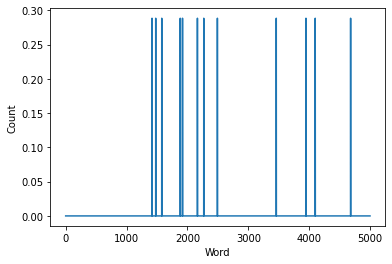

In [ ]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_words = 5000
max_len= 60

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
After Tokenization & Padding 
 [  94    5 3498    1   11   16  250  336    5  655  124   88    5  150
 2796   29   10  424    1   11   10  747    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (2907, 60) (2907, 3)
Validation Set -> (969, 60) (969, 3)
Test Set -> (970, 60) (970, 3)


In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs= 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



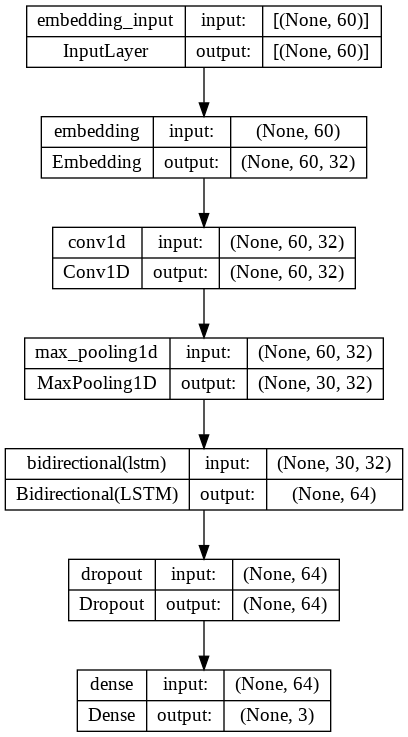

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 60, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=1)
# Print metrics
# print('')
# print('Accuracy  : {:.4f}'.format(accuracy))
# print('Precision : {:.4f}'.format(precision))
# print('Recall    : {:.4f}'.format(recall))
# print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

31/31 [==============================] - 0s 6ms/step - loss: 1.6111 - accuracy: 0.6515 - precision: 0.6515 - recall: 0.6515


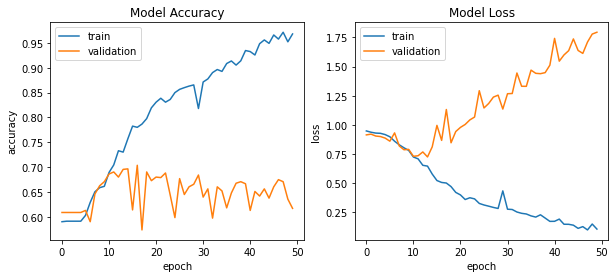

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

31/31 [==============================] - 1s 3ms/step


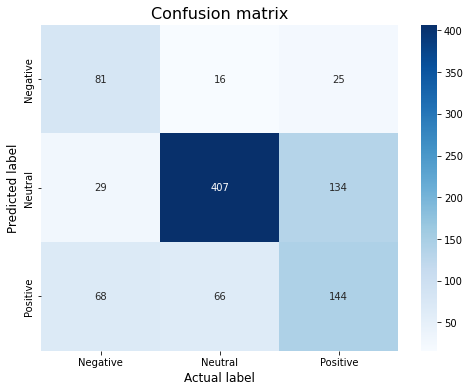

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [ ]:
from keras.models import load_model

# Load model
model = load_model('/content/best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=60
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print(yt[0])


    

In [ ]:
k = 'bANK Nifty crashed duue to Mahindra and Mahindra.'
predict_class([k])


1/1 [==============================] - 0s 16ms/step
0
